# Clasificador de tejido sano y tejido cancerígeno en imagenes microscópicas del esófago

![image.png](attachment:image.png)

#### Paso 1 - Cargar librerías, módulos y funciones que utilizaremos.

#### Paso 2 - Lectura de datos y adecuación de formato.

#### Paso 3 - Entrenamiento utilizando perceptrón simple con conjunto de entrenamiento y prueba

#### Paso 4. Entrenamiento de perceptron utilizando el método de validación K-fold Cross Validation

## Paso 1. Cargar librerías y módulos requerdidos

In [46]:
import os            #módulo para manejar carpetas y archivos en nuestro ordenador
import random        #módulo para aleatorizar

import numpy as np   #librería para manejar matrices y operaciones de matrices 
import pandas as pd  #librería para manejar tablas de datos


                                       #Skimage (Scikit-image): librería para procesamiento de imagenes
from skimage import io                 #Modulo para leer una imagen (librería para procesamiento de imagenes)
#from skimage.transform import rescale  #Función dentro del modulo transform, para cambiar el tamaño de una imagen 


                                                       #Sklearn (Scikit-learn): librería para machine learning 
from sklearn.model_selection import train_test_split   
from sklearn.linear_model import Perceptron 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt        #Para graficar y visualizar
import seaborn as sns


# para especificar que queremos las graficas en linea sin necesidad de usar plt.show()
%matplotlib inline      

## Paso 2. Lectura de datos. 

X=Imagenes
Y=Etiqueta con la clase a la que pertenece

Para X, Scikilearn admite arreglos de dos dimensiones ( ya sea un np.arrays de dos dimensiones o un data frame de pandas)

Para Y, puede ser un vector, o matriz de una sola dimensión, de np.arrays o una serie de pandas)


### 2.1 Lectura de etiquetas (Y)

Para leer un archivo en Python, debemos indicar la carpeta donde se encuentra.

Para obtener la ruta podemos copiarla desde nuestro explorador de archivos.
En Windows deberemos remplazar el símbolo la diagonal invertida \ por / o bien \\  

Ejemplo:

Remplazar  'C:\mydir'

Por        'C:/mydir'
o bien     'C:\\mydir'



In [57]:
#Leemos los datos

datos = pd.read_csv('/content/drive/MyDrive/Datos/DatosCancer/ClasesImagenes.csv')

In [58]:
datos.head()  #muestra los primeros cinco registros

,Unnamed: 0,image_filename,class_number
0,0,im_4_0.png,0
1,1,im_21_0.png,0
2,2,im_9_0.png,0
3,3,im_8_0.png,0
4,4,im_15_0.png,0


In [49]:
#¿Con cuántas imagenes vamos a trabajar?

datos.shape[0]

5063

In [50]:
#¿cuántas imagenes tenemos de cada clase?

datos['class_number'].value_counts(sort=False)  

0    1469
1    3594
Name: class_number, dtype: int64

Clase 0 corresponde a tejido sano y Clase 1 a tejido Cancerígeno

In [51]:
Y=datos.class_number   #Guardamos las etiquetas de las imagenes como serie de pandas


### 2.2 Lectura de imágenes (X)

Para descomprimir archivo zip con python podemos usar las siguientes lineas de código: 


```
from zipfile import ZipFile
with ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
```



In [59]:
#Al nombre de cada imagen necesitamos añadirle la ruta del directorio en el que se encuentra 

image_path = "/content/drive/MyDrive/Datos/Carpeta Imagenes cancer unzip"
datos['image_filename'] = datos['image_filename'].apply(lambda x: [os.path.join(image_path, x)])
datos['image_filename'] = datos['image_filename'].str.get(0)

datos.head(3)

,Unnamed: 0,image_filename,class_number
0,0,/content/drive/MyDrive/Datos/Carpeta Imagenes ...,0
1,1,/content/drive/MyDrive/Datos/Carpeta Imagenes ...,0
2,2,/content/drive/MyDrive/Datos/Carpeta Imagenes ...,0


In [60]:
#Cargamos las imagenes del conjunto d entrenamiento como lista de matrices (np.arrays)
# (3 min en mi computadora)

%time img= [io.imread(i, as_gray=True) for i in datos['image_filename'][:]]


CPU times: user 33 s, sys: 34.5 s, total: 1min 7s
Wall time: 1min 17s


In [61]:
img[1].shape   # dimensión 67,200

(260, 260)

In [ ]:
img[1]

array([[0.08322275, 0.08322275, 0.08322275, ..., 0.08322275, 0.08322275,
        0.08322275],
       [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275, 0.08322275,
        0.08322275],
       [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275, 0.08322275,
        0.08322275],
       ...,
       [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275, 0.08322275,
        0.08322275],
       [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275, 0.08322275,
        0.08322275],
       [0.08322275, 0.08322275, 0.08322275, ..., 0.08322275, 0.08322275,
        0.08322275]])

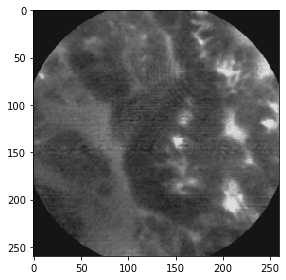

In [ ]:
io.imshow(img[500]) 

- Dimensión 0: 260 renglones de pixeles de arriba a abajo
- Dimensión 1: 260 columnas de pixeles de izquierda a derecha


####  Transformar imágenes en vectores
Lo primero es transformar la lista img en una matriz


In [ ]:
IMG =np.stack(img, axis=0)  # Toma una secuencia de matrices y las apila a lo largo 
                            # de un tercer eje para hacer una sola matriz              
IMG.shape

(5063, 260, 260)

Despues aplanar la matriz de 2D (260x260 pixeles) de cada imagen, para obtener un vector por imagen. 

In [ ]:
n_imagenes=len(IMG)
X = IMG.reshape((n_imagenes, -1))
X.shape

(5063, 67600)

##### Visualizamos ejemplos de ambas clases de imagenes

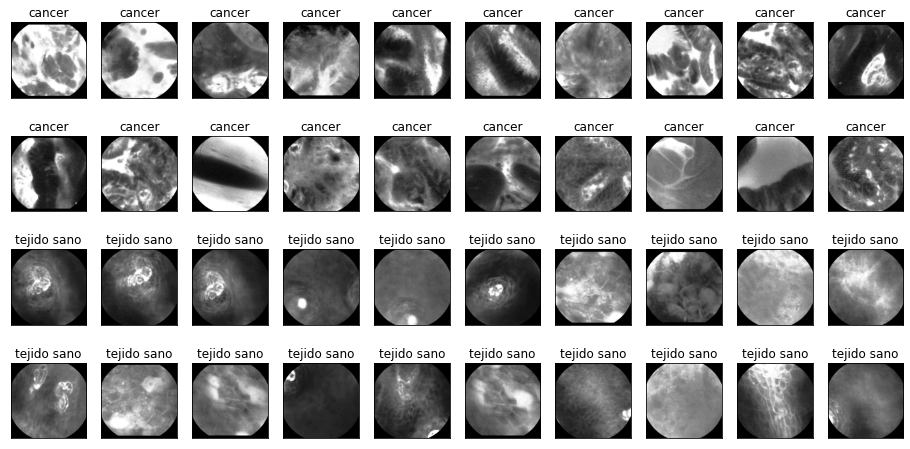

In [ ]:
#El método GroupBy de Pandas separa un data frame en varios data frames
porClase=datos.groupby('class_number')

#elije al azar n muestras de cada subconjunto y guarda la posición de las figuras elegidas en una lista
n=20
c=random.sample(porClase.get_group(1).index.tolist(),n)
s=random.sample(porClase.get_group(0).index.tolist(),n)

# Grafica 20 imágenes aleatorias de tejido con cáncer y 20 de tejido sano

fig=plt.figure(figsize=(16, 8))
columns = 10
rows = 4
for i in range(0, columns*rows):
    fig.add_subplot( rows, columns, i+1)
    if i < 20:
        plt.imshow(img[c[i]], cmap='Greys_r')
        plt.title('cancer')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow(img[s[i-20]], cmap='Greys_r')
        plt.title('tejido sano')
        plt.xticks([])
        plt.yticks([])
plt.show()

## Paso 3. Entrenamiento utilizando perceptrón simple con conjunto de entrenamiento y prueba

### 3.1  Crear subconjuntos de entrenamiento y prueba



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=0)

In [ ]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Training set")
print("X: ", X_train.shape)
print("Y: ", y_train.shape)
unique, counts= np.unique(y_train, return_counts=True)
print('Tejido Sano:        ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')


print("Test set")
print("X: ", X_test.shape)
print("Y: ", y_test.shape)
unique, counts= np.unique(y_test, return_counts=True)
print('Tejido Sano:         ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')

Training set
X:  (3544, 67600)
Y:  (3544,)
Tejido Sano:         1043 
Displasia o Cáncer:  2501 

Test set
X:  (1519, 67600)
Y:  (1519,)
Tejido Sano:          426 
Displasia o Cáncer:  1093 



### 3.2  Entrenamiento



In [ ]:
%%time
model = Perceptron(max_iter=45,  random_state=0) 

model.fit(X_train,y_train)                                   


print("Iterations: ", model.n_iter_)
print("Number of weight updates perfomed during training: ", model.t_, "\n")

print("Accuracy: %.2f%%" % (model.score(X_test,y_test)*100.0)) 

Iterations:  44
Number of weight updates perfomed during training:  155937.0 

Accuracy: 90.19%
Wall time: 36.9 s


In [ ]:
#Guardamos los coeficientes del modelo como beta

beta=model.coef_
print(beta.shape)

(1, 67600)


In [ ]:
beta[0, 50310:50320]

array([ -1.92002706,  26.43550275,  48.33832196,  60.5412651 ,
        36.79920392,  20.46658157,  -2.35208118, -16.18895686,
       -16.80207686,   4.81493412])

In [ ]:
y_predict=model.predict(X_test)  #pasa cada una de las imágenes de X_test por el modelo 

In [ ]:
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_predict)*100))

Accuracy: 90.19%


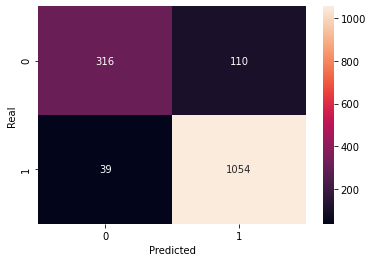

In [ ]:
#Matriz de confusión

data = {'Y_Real':  y_test,
        'Y_Prediccion':y_predict
        }

df = pd.DataFrame(data, columns=['Y_Real','Y_Prediccion'])
confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

In [ ]:
y_test.value_counts()

1    1093
0     426
Name: class_number, dtype: int64

## Paso 4. Entrenamiento de perceptron utilizando el método de validación K-fold Cross Validation 

(4 min aprox)

In [ ]:
%%time

kfold=KFold(n_splits=5,random_state=0,  shuffle=True)
model_kfold=Perceptron(alpha=0.0001, fit_intercept=True, max_iter=1000, tol=0.001, eta0=1.0, random_state=0, early_stopping=False)
result_kfold=cross_val_score(model_kfold, X, Y, cv=kfold )
print("Accuracy: %.2f (+/- %02f)" % (result_kfold.mean(),result_kfold.std()))

Accuracy: 0.89 (+/- 0.037545)
Wall time: 4min 22s


In [ ]:
result_kfold

array([0.83415597, 0.90720632, 0.93089832, 0.9298419 , 0.86857708])

# Ejercicio

1. Variar el número máximo de iteraciones (max_iter) al crear el modelo con Perceptron, utilizando 10, 20, 30, 40, 50, 100, 200 y observar la variación de la precición (accuracy)
2. Entrenar el perceptrón , considerando un conjunto de prueba y otro de entrenamiento,  variando el tamaño del conjunto de datos, usando 25%,  50% , y 75% del total de imágenes (pista: para crear un subconjunto de datos con el 25% de las imágenes usar el filtro mask como se muestra en la siguiente celda).

In [ ]:
#Muestra de base de datos con el 25% de los casos
mask = np.random.choice([False, True], len(X), p=[0.75, 0.25])
X25=X[mask]
Y25=Y[mask]
